# FENE beadspring with variable kuhn length experiment data analysis

In [34]:
import os

import polyflexmd.data_analysis.data.read as read
import polyflexmd.data_analysis.transform.transform as transform
import polyflexmd.data_analysis.plot.plot_system as plot_system
import polyflexmd.experiment_runner.config as config
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from pandarallel import pandarallel
import dask
import dask.dataframe
import multiprocessing
import seaborn as sns


In [2]:
%load_ext autoreload
%autoreload 2

In [39]:
sns.set_style("darkgrid")

In [3]:
pandarallel.initialize(
    nb_workers=len(os.sched_getaffinity(0)),
    progress_bar=False,
    use_memory_fs=False
)

INFO: Pandarallel will run on 64 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


## Read and process data

In [120]:
PATH_EXPERIMENT = "/scratch/ws/0/s4610340-bt-eea1-md-workspace/.dev/test-results/FENE-beadspring-vary-l_K/test-4-FENE-beadspring-vary-l_K-taurus/e64ff746"
NAME_EC = "test-4-FENE-beadspring-vary-l_K-taurus.toml"

In [121]:
PATH_EXPERIMENT = pathlib.Path(PATH_EXPERIMENT)
PATH_SYSTEM_DEF = PATH_EXPERIMENT / "data/initial_system.data"
PATH_EC = PATH_EXPERIMENT / NAME_EC

### Read experiment config

In [122]:
conf = config.read_experiment_config(PATH_EC)
conf

ExperimentConfig(simulation_config=SimulationConfig(job=SlurmJobConfig(account='p_mdpolymer', time='1:00:00', partition='romeo', ntasks=20, cpus_per_task=6, mem_per_cpu=3000), simulation_model_path=PosixPath('simulations/FENE-beadspring-vary-l_K.lammps'), experiments_path=PosixPath('/scratch/ws/0/s4610340-bt-eea1-md-workspace/.dev/test-results'), variables={'kappa': [1.0, 4.0, 7.0, 10.0, 13.0, 20.0, 30.0, 40.0, 50.0], 'n_relax_steps': 100000, 'n_equilibrium_steps': 100000}), system_creator_config=SystemCreatorConfig(job=SlurmJobConfig(account='p_mdpolymer', time='1:00:00', partition='romeo', ntasks=1, cpus_per_task=4, mem_per_cpu=1000), venv_path=PosixPath('/scratch/ws/0/s4610340-bt-eea1-md-workspace/polyflexmd/.venv'), system_config=AnchoredFENEChainConfig(name='anchored-fene-chain', n_chains=10, n_monomers=128, monomer_type=2, bond_type=1, angle_type=1, bond_length=0.97, box_length=200, seed=77)), report_config=ReportConfig(job=SlurmJobConfig(account='p_mdpolymer', time='1:00:00', pa

In [123]:
kappas: list[float] = conf.simulation_config.variables["kappa"]
kappas

[1.0, 4.0, 7.0, 10.0, 13.0, 20.0, 30.0, 40.0, 50.0]

### Read initial system

In [124]:
system = read.read_lammps_system_data(PATH_SYSTEM_DEF)
system.atoms

,molecule-ID,type,x,y,z,ix,iy,iz
1,1,1,0.000000,0.000000,0.000000,0,0,0
2,1,1,0.764233,-0.425729,-0.419050,0,0,0
3,1,2,0.773821,-0.836732,0.459520,0,0,0
4,1,2,1.285179,-0.524169,-0.303184,0,0,0
5,1,2,0.842282,0.329744,-0.427985,0,0,0
...,...,...,...,...,...,...,...,...
1276,10,2,-5.040273,-4.076050,0.165455,0,0,0
1277,10,2,-5.053418,-5.044302,0.222144,0,0,0
1278,10,2,-5.044456,-5.012970,1.191597,0,0,0
1279,10,2,-4.789053,-4.645573,2.052230,0,0,0


In [125]:
system.bonds

,type,atom1,atom2
1,1,1,2
2,1,2,3
3,1,3,4
4,1,4,5
5,1,5,6
...,...,...,...
1266,1,1275,1276
1267,1,1276,1277
1268,1,1277,1278
1269,1,1278,1279


In [126]:
system.angles

,type,atom1,atom2,atom3
1,1,1,2,3
2,1,2,3,4
3,1,3,4,5
4,1,4,5,6
5,1,5,6,7
...,...,...,...,...
1256,1,1274,1275,1276
1257,1,1275,1276,1277
1258,1,1276,1277,1278
1259,1,1277,1278,1279


In [127]:
system.box

-100.000000 100.000000  xlo xhi
-100.000000 100.000000  ylo yhi
-100.000000 100.000000  zlo zhi

### Read and process trajectories

In [128]:
PATH_DATA_PROCESSED = PATH_EXPERIMENT / "data" / "processed"
PATH_DATA_PROCESSED.mkdir(exist_ok=True)
PATH_DF_TRAJECTORY_PROCESSED = PATH_DATA_PROCESSED / "trajectory_unfolded_kappas.csv"
PATH_DF_TRAJECTORY_PROCESSED

PosixPath('/scratch/ws/0/s4610340-bt-eea1-md-workspace/.dev/test-results/FENE-beadspring-vary-l_K/test-4-FENE-beadspring-vary-l_K-taurus/e64ff746/data/processed/trajectory_unfolded_kappas.csv')

In [129]:
def read_and_process_kappas_df(experiment_path: pathlib.Path, kappas: list[float]):
    dfs = []
    for i in range(1, len(kappas) + 1):
        paths_trajectories = [
            experiment_path / "data" / f"polymer_relax-{i}.out",
            experiment_path / "data" / f"polymer-{i}.out"
        ]
        print(f"Reading {paths_trajectories}...")
        if not all(p.exists() for p in paths_trajectories):
            break

        df_trajectory_unfolded = transform.unfold_coordinates_df(
            trajectory_df=transform.join_raw_trajectory_df_with_system_data(
                raw_trajectory_df=read.read_multiple_raw_trajectory_dfs(paths_trajectories),
                system_data=system
            ),
            system_data=system
        )
        df_trajectory_unfolded["kappa"] = kappas[i-1]
        dfs.append(df_trajectory_unfolded)

    return pd.concat(dfs)


if PATH_DF_TRAJECTORY_PROCESSED.exists():
    print("Reading processed...")
    df_trajectory_unfolded_kappas = pd.read_csv(PATH_DF_TRAJECTORY_PROCESSED)
else:
    print("Reading and processing...")
    df_trajectory_unfolded_kappas = read_and_process_kappas_df(PATH_EXPERIMENT, kappas)
    print("Writing...")
    df_trajectory_unfolded_kappas.to_csv(PATH_DF_TRAJECTORY_PROCESSED, index=False)

df_trajectory_unfolded_kappas

Reading and processing...
Reading [PosixPath('/scratch/ws/0/s4610340-bt-eea1-md-workspace/.dev/test-results/FENE-beadspring-vary-l_K/test-4-FENE-beadspring-vary-l_K-taurus/e64ff746/data/polymer_relax-1.out'), PosixPath('/scratch/ws/0/s4610340-bt-eea1-md-workspace/.dev/test-results/FENE-beadspring-vary-l_K/test-4-FENE-beadspring-vary-l_K-taurus/e64ff746/data/polymer-1.out')]...
Reading [PosixPath('/scratch/ws/0/s4610340-bt-eea1-md-workspace/.dev/test-results/FENE-beadspring-vary-l_K/test-4-FENE-beadspring-vary-l_K-taurus/e64ff746/data/polymer_relax-2.out'), PosixPath('/scratch/ws/0/s4610340-bt-eea1-md-workspace/.dev/test-results/FENE-beadspring-vary-l_K/test-4-FENE-beadspring-vary-l_K-taurus/e64ff746/data/polymer-2.out')]...
Reading [PosixPath('/scratch/ws/0/s4610340-bt-eea1-md-workspace/.dev/test-results/FENE-beadspring-vary-l_K/test-4-FENE-beadspring-vary-l_K-taurus/e64ff746/data/polymer_relax-3.out'), PosixPath('/scratch/ws/0/s4610340-bt-eea1-md-workspace/.dev/test-results/FENE-beads

,t,id,type,x,y,z,ix,iy,iz,molecule-ID,kappa
0,0,1,1,0.000000,0.000000,0.000000,0,0,0,1,1.0
1,0,2,1,0.764233,-0.425729,-0.419050,0,0,0,1,1.0
2,0,3,2,0.773821,-0.836732,0.459520,0,0,0,1,1.0
3,0,4,2,1.285180,-0.524169,-0.303184,0,0,0,1,1.0
4,0,5,2,0.842282,0.329744,-0.427985,0,0,0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...
1275,200000,1276,2,-15.881500,8.092570,17.671800,0,0,0,10,50.0
1276,200000,1277,2,-16.058800,7.957780,18.613600,0,0,0,10,50.0
1277,200000,1278,2,-16.247500,7.928560,19.523900,0,0,0,10,50.0
1278,200000,1279,2,-16.495000,7.502110,20.376600,0,0,0,10,50.0


In [130]:
df_trajectory_unfolded_kappas.groupby(["kappa"])["t"].describe()

,count,mean,std,min,25%,50%,75%,max
kappa,,,,,,,,
1.0,16640.0,134615.384615,50325.903708,0.0,110000.0,140000.0,170000.0,200000.0
4.0,16640.0,134615.384615,50325.903708,0.0,110000.0,140000.0,170000.0,200000.0
7.0,16640.0,134615.384615,50325.903708,0.0,110000.0,140000.0,170000.0,200000.0
10.0,16640.0,134615.384615,50325.903708,0.0,110000.0,140000.0,170000.0,200000.0
13.0,16640.0,134615.384615,50325.903708,0.0,110000.0,140000.0,170000.0,200000.0
20.0,16640.0,134615.384615,50325.903708,0.0,110000.0,140000.0,170000.0,200000.0
30.0,16640.0,134615.384615,50325.903708,0.0,110000.0,140000.0,170000.0,200000.0
40.0,16640.0,134615.384615,50325.903708,0.0,110000.0,140000.0,170000.0,200000.0
50.0,16640.0,134615.384615,50325.903708,0.0,110000.0,140000.0,170000.0,200000.0


## Calculate and plot observables

### Mean bond length

In [131]:
l_b = conf.system_creator_config.system_config.bond_length
l_b

0.97

### Mean contour length

In [132]:
L_contour = l_b*(conf.system_creator_config.system_config.n_monomers-1)
L_contour

123.19

### End-to-End distance $\vec{R}$

In [133]:
PATH_ETE = PATH_EXPERIMENT / "data" / "processed" / "ete.csv"

if PATH_ETE.exists():
    print("Reading processed...")
    df_ete = pd.read_csv(PATH_DF_TRAJECTORY_PROCESSED)
else:
    print("Processing...")
    df_ete = df_trajectory_unfolded_kappas.groupby("kappa").apply(transform.calc_end_to_end_df)
    print("Writing...")
    df_ete.to_csv(PATH_ETE, index=True)

df_ete

Processing...
Writing...


R_x       R_y       R_z          R
kappa molecule-ID t                                              
1.0   1           0        9.84474 -2.701840   7.54827  12.696268
                  100000   9.24134 -3.715290   6.02826  11.642408
                  110000   9.68555  1.058190   4.55192  10.754051
                  120000  10.38320  1.415410   5.85353  12.003251
                  130000   8.95613 -0.885769   5.70371  10.655006
...                            ...       ...       ...        ...
50.0  10          160000 -11.50650 -2.342270  23.75680  26.500402
                  170000  -7.95021  2.393510  24.31790  25.696206
                  180000 -10.81680  5.113980  22.21330  25.230669
                  190000 -15.76690  8.649000  21.49090  28.022475
                  200000 -16.70400  7.029360  21.20300  27.892700

[1080 rows x 4 columns]

In [134]:
df_ete["t/LJ"] = df_ete.index.get_level_values("t").map(lambda x: x * 0.0025)
df_ete["R^2"] = df_ete["R"] ** 2
df_ete

R_x       R_y       R_z          R   t/LJ  \
kappa molecule-ID t                                                        
1.0   1           0        9.84474 -2.701840   7.54827  12.696268    0.0   
                  100000   9.24134 -3.715290   6.02826  11.642408  250.0   
                  110000   9.68555  1.058190   4.55192  10.754051  275.0   
                  120000  10.38320  1.415410   5.85353  12.003251  300.0   
                  130000   8.95613 -0.885769   5.70371  10.655006  325.0   
...                            ...       ...       ...        ...    ...   
50.0  10          160000 -11.50650 -2.342270  23.75680  26.500402  400.0   
                  170000  -7.95021  2.393510  24.31790  25.696206  425.0   
                  180000 -10.81680  5.113980  22.21330  25.230669  450.0   
                  190000 -15.76690  8.649000  21.49090  28.022475  475.0   
                  200000 -16.70400  7.029360  21.20300  27.892700  500.0   

                                 R^2  
kappa molecule-ID t                   
1.0   1           0       161.195225  
                  100000  135.545663  
                  110000  115.649621  
                  120000  144.078041  
                  130000  113.529159  
...                              ...  
50.0  10          160000  702.271317  
                  170000  660.294990  
                  180000  636.586651  
                  190000  785.259119  
                  200000  778.002727  

[1080 rows x 6 columns]

In [135]:
df_ete_mean = df_ete.groupby(["kappa", "t/LJ"])[["R^2"]].mean()
df_ete_mean

R^2
kappa t/LJ             
1.0   0.0    128.180231
      250.0  121.048280
      275.0  137.876392
      300.0  159.379333
      325.0  161.788656
...                 ...
50.0  400.0  463.433740
      425.0  501.627391
      450.0  588.570285
      475.0  651.960556
      500.0  663.554320

[108 rows x 1 columns]

<Axes: title={'center': '$\\langle R \\rangle$'}, xlabel='t/LJ', ylabel='distance / $\\langle L \\rangle$'>

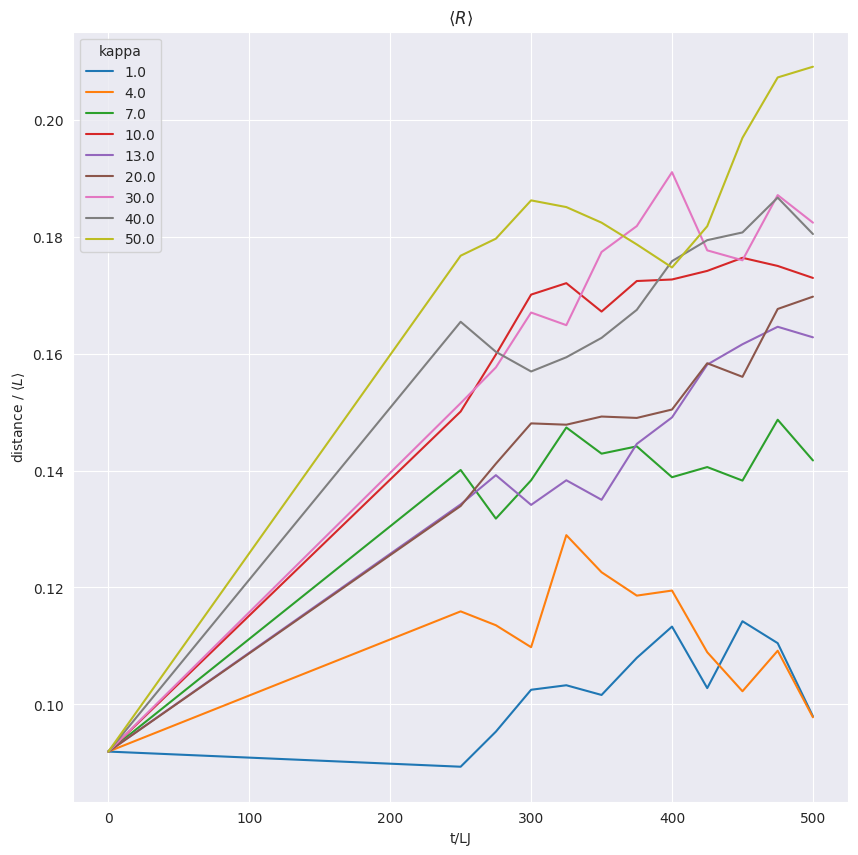

In [138]:
kappa_colors = sns.color_palette(n_colors=len(kappas))

ax: plt.Axes
fig: plt.Figure
fig, ax = plt.subplots(figsize=(10,10))
ax.set(
    title='$\\langle R \\rangle$',
    ylabel="distance / $\\langle L \\rangle$"
)

sns.lineplot(
    x=df_ete_mean.index.get_level_values("t/LJ"),
    y=np.sqrt(df_ete_mean["R^2"]) / L_contour,
    hue=df_ete_mean.index.get_level_values("kappa").astype("category"),
    color=kappa_colors,
    ax=ax
)

### dR

In [158]:
def calculate_ens_avg_df_ete_change_kappas(df_ete_kappas: pd.DataFrame) -> pd.DataFrame:
    dfs_ete_change_kappas = []
    for kappa, df_ete_kappa in df_ete_kappas.groupby("kappa"):
        df_ete_change_kappa = pd.DataFrame(transform.calculate_ete_change_ens_avg_df(df_ete_kappa.droplevel("kappa")), columns=["dR^2"])
        df_ete_change_kappa["kappa"] = kappa
        df_ete_change_kappa["t/LJ"] = df_ete_change_kappa.index.get_level_values("t").map(lambda x: x * 0.0025)
        df_ete_change_kappa.set_index(["kappa", "t/LJ"], inplace=True)
        dfs_ete_change_kappas.append(df_ete_change_kappa)
    return pd.concat(dfs_ete_change_kappas)

df_ete_change_kappas = calculate_ens_avg_df_ete_change_kappas(df_ete)
df_ete_change_kappas

dR^2
kappa t/LJ             
1.0   0.0      0.000000
      250.0   39.634773
      275.0   52.656999
      300.0   63.665493
      325.0   63.983767
...                 ...
50.0  400.0  277.324803
      425.0  306.638785
      450.0  346.683033
      475.0  384.949092
      500.0  400.719490

[108 rows x 1 columns]

<Axes: title={'center': '$\\langle dR \\rangle$'}, xlabel='t/LJ', ylabel='distance / $\\langle L \\rangle$'>

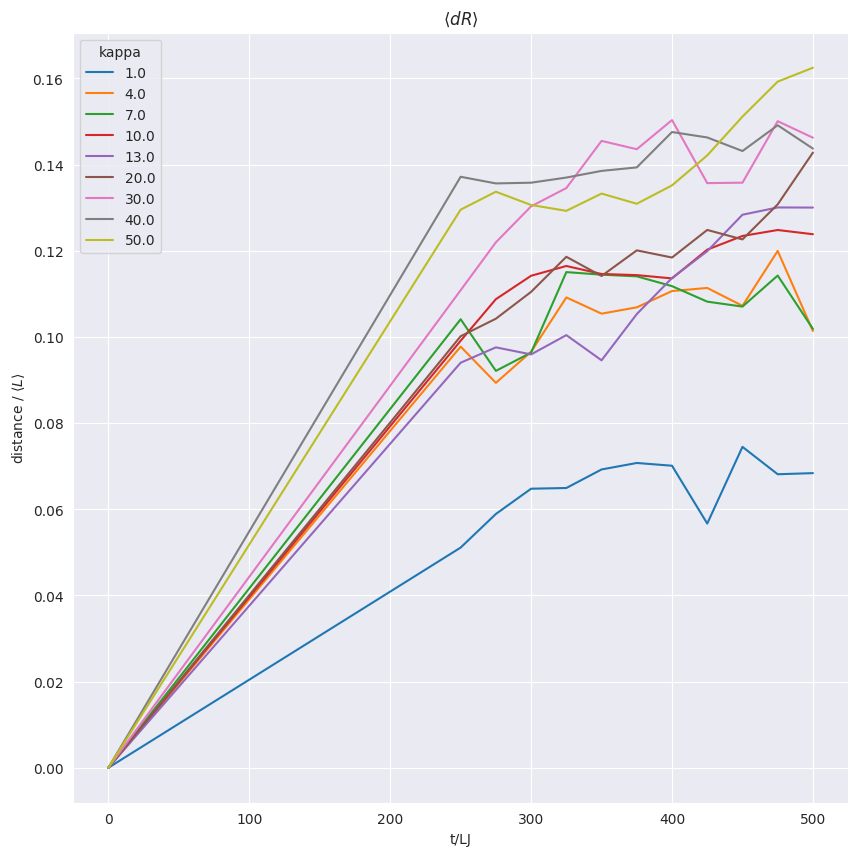

In [159]:
ax: plt.Axes
fig: plt.Figure
fig, ax = plt.subplots(figsize=(10,10))
ax.set(
    title='$\\langle dR \\rangle$',
    ylabel="distance / $\\langle L \\rangle$"
)

sns.lineplot(
    x=df_ete_change_kappas.index.get_level_values("t/LJ"),
    y=np.sqrt(df_ete_change_kappas["dR^2"]) / L_contour,
    hue=df_ete_change_kappas.index.get_level_values("kappa").astype("category"),
    color=kappa_colors,
    ax=ax
)